This notebook is mainly for messing around with Geopandas objects and figuring out what the best way is to plan a path\
To run this code, you need to install shapely, geopandas matplotlib and numpy 

In [21]:
import json
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import LineString,MultiLineString
import geopandas as gpd
import numpy as np
import pandas as pd
import math
from dubins_curves import *

In [2]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_2.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

In [3]:
# This cell opens the json file that contains field geometry
with open("./data/field_geometry/test_2.json") as json_file:
    json_data = json.load(json_file) # or geojson.load(json_file)

# This cell parses the json data and obtains a list with the coordinates for each polygon like
# [[polygon1_coords],[polygon2_coords],....]
# where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
coordinates = []
for i in range(len(json_data['features'])):
    coordinates.append(json_data['features'][i]['geometry']['coordinates'])

In [4]:
coordinates[0][0]

[[358.37, 546.33],
 [595.18, 502.9],
 [529.97, 22.56],
 [513.55, 18.56],
 [294.72, 51.94],
 [281.7, 62.66],
 [358.37, 546.33]]

<Axes: >

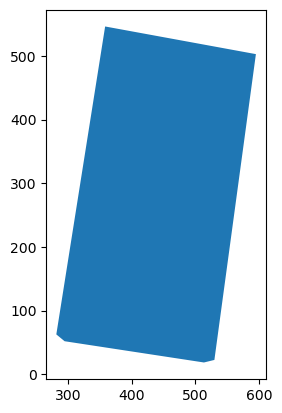

In [5]:
# Here we create a geoseries object from the polygons 
polygon1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
# hole = gpd.GeoSeries(Polygon(coordinates[2][0]))
# Creating a buffer with a specific size (in this case 1)
# obstacle_buffer = hole.buffer(1)
polygon1_buffer = polygon1.buffer(-10)
# hole.plot()
polygon1.plot()

In [6]:
# Here we substract the hole from the field, the first line does this for the field and hole without headlands, the second line does it
# for field and hole with headlands

# Uncomment these lines if you want to have a hole in your field
# field = polygon1.symmetric_difference(hole) 
# field_with_headlands = polygon1_buffer.symmetric_difference(obstacle_buffer)


field = polygon1
field_with_headlands = polygon1_buffer

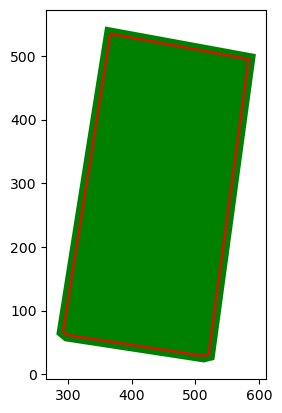

In [7]:
# Plotting the field (green) and headland boundaries
fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
plt.show()

In [8]:
# An easy way to obtain x and y coordinates for a polygon or polyline
polygon1.get_coordinates()

,x,y
0,358.37,546.33
0,595.18,502.90
0,529.97,22.56
0,513.55,18.56
0,294.72,51.94
0,281.70,62.66
0,358.37,546.33


C:\Users\hidde\AppData\Local\Temp\ipykernel_22672\1918966130.py:15: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  swath_clipped.plot(ax = ax, color = 'magenta')


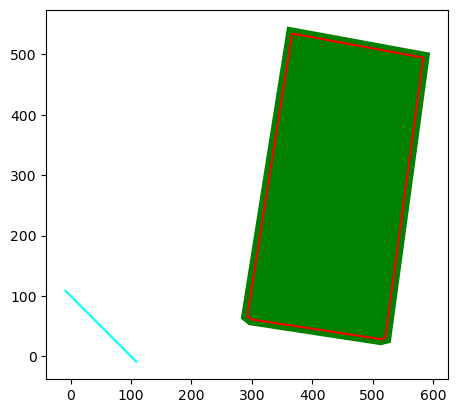

In [9]:
# Creating straight lines as vectors and clipping them to the field boundaries
vector = [[-10,110],[110,-10]]
# Here we make another geoseries object from the vector
swath = gpd.GeoSeries(LineString(vector))
# and we clip the vector so that it only covers the field and does not cross over into the headlands
swath_clipped = gpd.clip(swath,field_with_headlands)


# Plotting the original swath (cyan) and the clipped one (magenta)

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
swath.plot(ax = ax,color = 'cyan', marker = '+')
swath_clipped.plot(ax = ax, color = 'magenta')
plt.show()

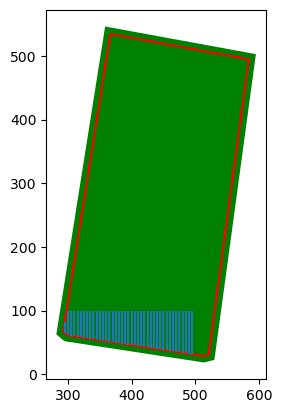

2162.9168561483148


In [10]:

# This cell combines the above cells and creates a bunch of parallel vectors with a fixed distance, clips them to the 
# boundaries of the field and then calculates the total length of the path

vector = []
for i in range(100):
    vector.append([[0+i*5,100],[0+i*5,0]])

swaths = []
swaths_clipped = []
for i in range(len(vector)):
    swaths.append(gpd.GeoSeries(LineString(vector[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax)
        total_swath_length+=swaths_clipped[i][0].length

plt.show()
print(total_swath_length)

In [11]:
# import numpy as np

def rotate_vector_z(vector, theta_z):
    # Convert angle to radians
    theta_z = np.radians(theta_z)

    # 2D Rotation matrix around the z-axis
    R_z = np.array([[np.cos(theta_z), -np.sin(theta_z)],
                    [np.sin(theta_z), np.cos(theta_z)]])

    # Rotate the vector
    rotated_vector = np.dot(R_z, vector)

    return rotated_vector

# Example usage
vector = np.array([1, 0])  # Example vector along the x-axis
theta_z = 45  # Rotation angle in degrees around z-axis

rotated_vector = rotate_vector_z(vector, theta_z)
print("Original Vector:", vector)
print("Rotated Vector around Z-axis:",rotated_vector)

Original Vector: [1 0]
Rotated Vector around Z-axis: [0.70710678 0.70710678]


In [12]:
# Example usage
vector = np.array([10000, 0])  # Example vector along the x-axis
for theta_z in range(0,95,5):
    # theta_z = 45  # Rotation angle in degrees around z-axis
    d = 10
    dx = d/(np.sin(np.radians(theta_z))+0.01)
    rotated_vector = rotate_vector_z(vector, theta_z)
    rotated_vector = [[0,0],list(rotated_vector)]
    vector_list = []
    if theta_z == 0:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
    else:
        for i in range(-10,10):
            vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



    swaths = []
    swaths_clipped = []
    for i in range(len(vector_list)):
        swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
        swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

    # fig, ax = plt.subplots()
    # field.plot(ax = ax, color = 'green')
    # field_with_headlands.boundary.plot(ax = ax,color = 'red')
    total_swath_length = 0
    for i in range(len(swaths_clipped)):
        if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length for vectors that are completely outside of the boundaries
            # swaths_clipped[i].plot(ax = ax)
            total_swath_length+=swaths_clipped[i][0].length

    # plt.show()
    
    print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))



Theta: 0.000000, total_length: 1162.250173
Theta: 5.000000, total_length: 2231.666540
Theta: 10.000000, total_length: 3212.082166
Theta: 15.000000, total_length: 4182.209563
Theta: 20.000000, total_length: 4878.830359
Theta: 25.000000, total_length: 5378.062301
Theta: 30.000000, total_length: 5781.004133
Theta: 35.000000, total_length: 6093.998788
Theta: 40.000000, total_length: 5760.347749
Theta: 45.000000, total_length: 4611.722952
Theta: 50.000000, total_length: 2772.733779
Theta: 55.000000, total_length: 1274.095000
Theta: 60.000000, total_length: 283.731502
Theta: 65.000000, total_length: 0.000000
Theta: 70.000000, total_length: 0.000000
Theta: 75.000000, total_length: 0.000000
Theta: 80.000000, total_length: 0.000000
Theta: 85.000000, total_length: 0.000000
Theta: 90.000000, total_length: 0.000000


Theta: 5.000000, total_length: 2231.666540


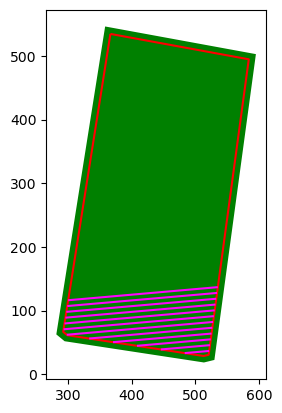

In [13]:
d = 10
theta_z = 5  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
# dx = d
vector = np.array([10000, 0])
rotated_vector = rotate_vector_z(vector, theta_z)
rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0],rotated_vector[0][1]+i*d],[rotated_vector[1][0],rotated_vector[1][1]+i*d]])
else:
    for i in range(-10,10):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])



swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field_with_headlands))

fig, ax = plt.subplots()
field.plot(ax = ax, color = 'green')
field_with_headlands.boundary.plot(ax = ax,color = 'red')
total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        swaths_clipped[i].plot(ax = ax,color = 'magenta')
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

plt.show()

1878.6717201392585

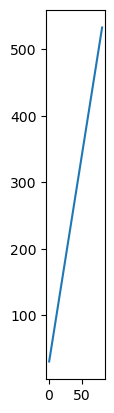

In [14]:
def linefromvec(vec):
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

vector = np.array([[308.976881,	75.054454],[379.051873,	517.120079]])
slope,intercept = linefromvec(vector)
# xmin = min(field1_with_headlands.get_coordinates()['x'])
# xmax = max(field1_with_headlands.get_coordinates()['x'])
# ymin = slope*xmin+intercept
# ymax = slope*xmax+intercept

ymin = min(field_with_headlands.get_coordinates()['y'])
ymax = max(field_with_headlands.get_coordinates()['y'])
xmin = ymin/slope-intercept
xmax = ymax/slope-intercept

# plt.plot(vector[0],vector[1])
vector = np.array([[xmin-xmin,ymin],[xmax-xmin,ymax]])

line = gpd.GeoSeries(LineString(vector))
fig, ax = plt.subplots()
line.plot(ax = ax)

xmin

Theta: 0.000000, total_length: 8679.986253


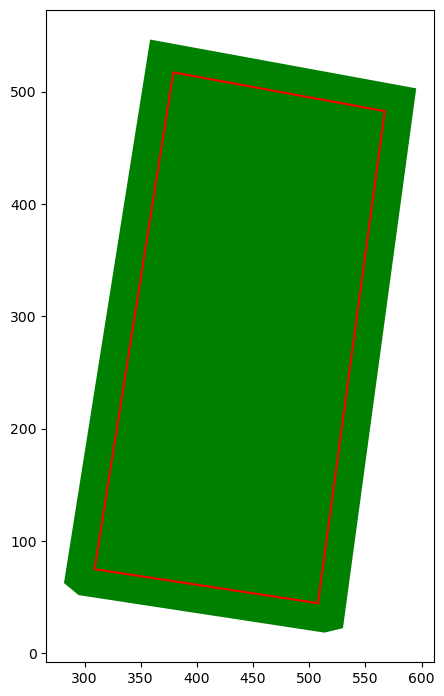

array([[  0.        ,  28.74373804],
       [ 80.19420004, 534.64603146]])

In [15]:
field1 = gpd.GeoSeries(Polygon(coordinates[0][0]))
field1_with_headlands = field1.buffer(-25)
fig, ax = plt.subplots(figsize = [5,10])
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')


d = 10
theta_z = 00  # Rotation angle in degrees around z-axis
dx = d/(np.sin(np.radians(theta_z))+0.01)
dx = 10
# dx = d
# vector = np.array([[xmin,ymin],[xmax,ymax]])
# rotated_vector = rotate_vector_z(vector, theta_z)
# rotated_vector = [[0,0],list(rotated_vector)]
vector_list = []
if theta_z == 0:
    for i in range(-100,100):
        vector_list.append([[vector[0][0]+i*d,vector[0][1]],[vector[1][0]+i*d,vector[1][1]]])
else:
    for i in range(-100,100):
        vector_list.append([[rotated_vector[0][0]+i*dx,rotated_vector[0][1]],[rotated_vector[1][0]+dx*i,rotated_vector[1][1]]])

swaths = []
swaths_clipped = []
for i in range(len(vector_list)):
    swaths.append(gpd.GeoSeries(LineString(vector_list[i])))
    swaths_clipped.append(gpd.clip(swaths[i],field1_with_headlands))

total_swath_length = 0
for i in range(len(swaths_clipped)):
    if not swaths_clipped[i].get_coordinates().empty: # This line is to make sure we don't calculate the length 
        #for vectors that are completely outside of the boundaries
        # swaths_clipped[i].plot(ax = ax,color = 'magenta')
        # swaths[i].plot
        total_swath_length+=swaths_clipped[i][0].length
print('Theta: {:6f}, total_length: {:6f}'.format(theta_z,total_swath_length))

fig.savefig('./data/images/field_with_headlangs.svg', format='svg')
plt.show()

# swaths_clipped[15].get_coordinates()
vector

In [16]:

swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
list_coords = []
for i in range(len(swaths_clipped_nonempty)):
    list_coords.append(swaths_clipped_nonempty[0].get_coordinates())


In [17]:
field1_with_headlands.get_coordinates()

,x,y
0,308.976881,75.054454
0,379.051873,517.120079
0,567.196830,482.615052
0,507.750939,44.733758
0,308.976881,75.054454


In [18]:
np.array([379.051873,	517.120079])-np.array([308.976881,	75.054454])
# swaths_clipped_nonempty

array([ 70.074992, 442.065625])

In [19]:
from dubins_curves import *

line1 = swaths_clipped_nonempty[0]
line2 = swaths_clipped_nonempty[1]
line1_coords = line1.get_coordinates()
line2_coords = line2.get_coordinates()
point1 = line1_coords.iloc[1]
point2 = line2_coords.iloc[1]



diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
slope1 = diff1['y']/diff1['x']
heading_1 = math.degrees(math.atan(slope1))

diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
slope2 = diff2['y']/diff1['x']
heading_2 = math.degrees(math.atan(slope2))+180

pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)
turning_rad = 5

path = dubins_main(pt1,pt2,turning_rad)




In [20]:
# LineString(path)
curve1 = LineString(path[:,0:2])

<Axes: >

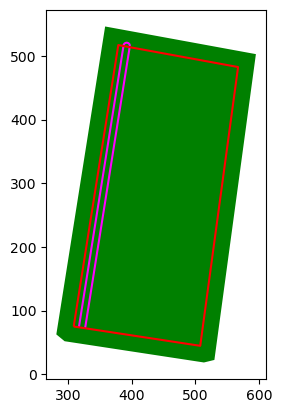

In [21]:
# MultiLineString((line1,curve1,line2))
line = gpd.GeoSeries((line1[0],curve1,line2[0]))
fig, ax = plt.subplots()
line.plot(ax = ax, color = 'magenta')
field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
# line1[0]

In [22]:

turning_rad = 10
line = []

for i in range(len(swaths_clipped_nonempty)-1):
    line1 = swaths_clipped_nonempty[i]
    line2 = swaths_clipped_nonempty[i+1]
    line1_coords = line1.get_coordinates()
    line2_coords = line2.get_coordinates()

    if i%2 != 0:
        point1 = line1_coords.iloc[0]
        point2 = line2_coords.iloc[0]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))+180

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))
        pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2)
    else:
        point1 = line1_coords.iloc[1]
        point2 = line2_coords.iloc[1]
        diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
        slope1 = diff1['y']/diff1['x']
        heading_1 = math.degrees(math.atan(slope1))

        diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
        slope2 = diff2['y']/diff1['x']
        heading_2 = math.degrees(math.atan(slope2))+180
        pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1)
        pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2)



    path = dubins_main(pt1,pt2,turning_rad)
    curve1 = LineString(path[:,0:2])
    line.append(gpd.GeoSeries((line1[0],curve1,line2[0])))
        


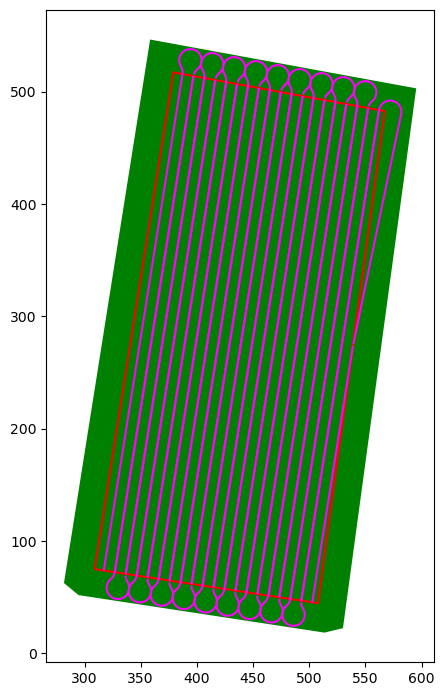

In [23]:

fig, ax = plt.subplots(figsize = [5,10])

field1.plot(ax = ax, color = 'green')
field1_with_headlands.boundary.plot(ax = ax, color = 'red')
for i in range(len(line)):
    line[i].plot(ax = ax, color = 'magenta')

fig.savefig('./data/images/field_generated_swaths.svg', format='svg')


In [24]:
line1_coords.iloc[1]


x    562.094722
y    483.550758
Name: 0, dtype: float64

In [25]:
import pandas as pd

geopandas.geoseries.GeoSeries

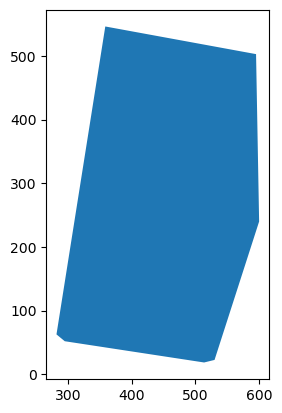

In [15]:
def load_data(filepath,include_obstacles = False):
    """
    function to load json file and create polygon object

    args:
        filepath (str): filepath that contains the json file to be parsed
        include_obstacles (bool): boolean to indicate if you want to include the obstacles in the resulting field (will probably be usefull for some debugging)

    returns:
        field (geopandas Geoseries)

    """
    # This cell opens the json file that contains field geometry
    with open("./data/field_geometry/test_2.json") as json_file:
        json_data = json.load(json_file) # or geojson.load(json_file)

    # This cell parses the json data and obtains a list with the coordinates for each polygon like
    # [[polygon1_coords],[polygon2_coords],....]
    # where polygon1_coords looks something like this: [[x1,y1],[x2,y2],......]
    coordinates = []
    polygons = []
    for i in range(len(json_data['features'])):
        coordinates.append(json_data['features'][i]['geometry']['coordinates'])
        polygons.append(gpd.GeoSeries(Polygon(coordinates[i][0])))
    
    field = polygons[0]
    if include_obstacles:
        for i in range(1,len(polygons)):
            field = field.symmetric_difference(polygons[i])

    return field

field = load_data("./data/field_geometry/test_2.json")
field.plot()
type(field)

In [3]:

def generate_headlands(field,size):
    field_with_headlands = field.buffer(-size)
    return field_with_headlands
        

def linefromvec(vec):
    """
    turn a vector in to a line in 2d with a slope and intercept

    attrs:
        vec (array): 2x2 array with x,y coords of begin point in first row, xy coords of end point in second row

    returns:
        slope (float): slope of the resulting line
        intercept (float): intercept of the resulting line

    """
    slope = (vec[1][1]-vec[0][1])/(vec[1][0]-vec[0][0])
    intercept = vec[1][1]-vec[1][0]*slope
    return slope,intercept

def edge_to_line(coordinates):
    """
    turns a df of field coordinates into a df with the slopes and intercepts of all edges of the field
    
    attrs:
        coordinates (geopandas DataFrame): a GeoPandas Dataframe containing the xy coordinates of all points that describe a polygon. Can be obtained using the get_coordinates() method
    returns:
        edge_lines (pandas DataFrame): a Pandas DF that contains slopes and intercepts of all lines describing the outline of a polygon
    
    """
    edge_points = len(coordinates)
    slopes = []
    intercepts = []
    for edge in range(edge_points-1):
        x_begin = coordinates.iloc[edge]['x']
        x_end = coordinates.iloc[edge+1]['x']
        y_begin = coordinates.iloc[edge]['y']
        y_end = coordinates.iloc[edge+1]['y']
        vector = np.array([[x_begin,y_begin],[x_end,y_end]])
        slope,intercept = linefromvec(vector)
        slopes.append(slope)
        intercepts.append(intercept)
    d = {'slope': slopes, 'intercept': intercepts}
    edge_lines = pd.DataFrame(data = d)
    return edge_lines
             
def basis_AB_line(edge,coordinates):  ## TODO: make the initial position align with the actual chosen edge, right now its just randomly placed somewhere
    """
    Creates an AB line to be used as basis for filling the field, the AB line has the same orientation as the given edge  
        and the length of the AB line is such that it covers the entire y-range of the field

    attrs:
        edge (Pandas Series): a slice of a dataframe containing the edge information, with the slope and intercept information of the 
                                edge for which you want to create a base AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon

    returns:   
        base_AB (numpy array): a line object that covers the entire y-range of the polygon with a direction
                                        specified in the edge attribute
    """
    slope = edge['slope']
    intercept = edge['intercept']
    ymin = min(coordinates['y'])
    ymax = max(coordinates['y'])
    xmin = ymin/slope-intercept
    xmax = ymax/slope-intercept
    if slope >= 0:
        vector = np.array([[xmin-xmin ,ymin],[xmax-xmin,ymax]])
    else:
        vector = np.array([[xmin-xmax ,ymin],[xmax-xmax,ymax]])
    # line = gpd.GeoSeries(LineString(vector))
    base_AB = vector
    return base_AB,slope

def fill_field_AB(base_AB,slope,coordinates,d):
    """
    takes the base AB line, its slope and a distance between lines and fills the field with AB lines of a given angle
    attrs:
        base_AB (array): array with xy coordinates of beginning and end points of the base vector
        slope (float): the slope of the basis AB line
        coordinates (pandas DataFrame): a pandas DF containing all the coordinates that describe the polygon
        d (float): distance between two AB lines

    returns:
        swath_list (list): a list containing Geoseries objects of different AB-lines
    """
    # Calculate angle of AB line wrt x-axis
    theta = np.arctan(slope)
    # using the angle and parameter d to calculate x-offset between swaths
    dx = d/(np.sin(theta)+0.01)

    # Determine amount of AB-lines that are needed
    xmax = max(coordinates['x'])
    xmin = min(coordinates['x'])
    nr_passes = int((xmax-xmin)//d + 2)*10

    # Initialize empty lists that will contain vectors and geoseries objects
    vector_list = []
    swath_list = []
    for swath in range(nr_passes):
        vector_list.append([[base_AB[0][0]+dx*swath,base_AB[0][1]],[base_AB[1][0]+dx*swath,base_AB[1][1]]])
        swath_list.append(gpd.GeoSeries(LineString(vector_list[swath])))
        # pass

    return swath_list

def clip_swaths(swath_list,field):
    """
    function to clip swaths to the headlands
    attrs:
        swath_list (list): List of geoseries objects that describe the generated swaths
        field (geopandas Geoseries): Geoseries object that describes the field geometry

    returns:
        swaths_clipped_nonempty (list): a list of geoseries objects that contains the clipped swaths that are not empty
    """
    swaths_clipped = []
    for swath in range(len(swath_list)):
        swaths_clipped.append(gpd.clip(swath_list[swath],field))
        swaths_clipped_nonempty = [swath for swath in swaths_clipped if not swath.get_coordinates().empty]
    if len(swaths_clipped_nonempty) == 0:
        raise Exception('No swaths were generated, something went wrong with clipping')
    return swaths_clipped_nonempty


def generate_path(swaths_clipped_nonempty,turning_rad,offset):
    turning_rad = 10
    line = []

    for i in range(len(swaths_clipped_nonempty)-1):
        line1 = swaths_clipped_nonempty[i]
        line2 = swaths_clipped_nonempty[i+1]
        line1_coords = line1.get_coordinates()
        line2_coords = line2.get_coordinates()

        if i%2 != 0:
            point1 = line1_coords.iloc[0]
            point2 = line2_coords.iloc[0]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))+180

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))
            pt1 = (line1_coords.iloc[0]['x'],line1_coords.iloc[0]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[0]['x'],line2_coords.iloc[0]['y'],90-heading_2+offset)
        else:
            point1 = line1_coords.iloc[1]
            point2 = line2_coords.iloc[1]
            diff1 = line1_coords.iloc[0]-line1_coords.iloc[1]
            slope1 = diff1['y']/diff1['x']
            heading_1 = math.degrees(math.atan(slope1))

            diff2 = line2_coords.iloc[0]-line2_coords.iloc[1]
            slope2 = diff2['y']/diff1['x']
            heading_2 = math.degrees(math.atan(slope2))+180
            pt1 = (line1_coords.iloc[1]['x'],line1_coords.iloc[1]['y'],90-heading_1+offset)
            pt2 = (line2_coords.iloc[1]['x'],line2_coords.iloc[1]['y'],90-heading_2+offset)



        path = dubins_main(pt1,pt2,turning_rad)
        curve1 = LineString(path[:,0:2])
        line.append(gpd.GeoSeries((line1[0])))
        line.append(gpd.GeoSeries(curve1))
    line.append(gpd.GeoSeries(line2[0]))
    return line

def interpolate_path(path,distance):
    """
    Function to interpolate the straight line segments of the path (otherwise they are simply a beginning and endpoint)
    args:
        path (list): list of geopandas Geoseries objects that describe the path
        distance (float): distance between interpolated points

    returns:
        path (list): list of geopandas Geoseries objects that has the same length as the input, 
                        but each straight line segment is split into more pieces
    """


    for i in range(len(path)): # Loop over the list of path segments
        if i%2 == 0: # We always start the path with a straight line, and then turns and straight lines alternate, so each even entry in the list is a straight line segment
            if i%4 ==0: # Every second straight line segment has to be reversed; each vector has the same direction, but the tractor
                        #should drive back and forth, so each 4th element in the row (every second straight path) reversed and then interpolated
                line = path[i][0]
                distances = np.arange(0,line.length,distance)
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                path[i] = gpd.GeoSeries(interpolated_path)
            else:
                line = path[i][0]
                distances = np.arange(line.length,0,-distance)
                interpolated_path = LineString([line.interpolate(distance) for distance in distances])
                path[i] = gpd.GeoSeries(interpolated_path)
        else: # Don't do anything if we have an odd index, those correspond to turns which are already interpolated. 
            continue
    return path
        
def path_to_df(best_path):
    """
    generates a df with the coordinates from the best path

    args:
        best_path (list): a list of linestring objects that define a path

    returns: 
        df_best_path (pandas DataFrame): a dateframe with x and y coordinates of the best path
    """
    coords = [x.get_coordinates() for x in best_path]
    df = pd.concat(coords)
    df_best_path = df.set_index((np.arange(len(df))))
    return df_best_path






In [5]:
field1_with_headlands = generate_headlands(field,25)

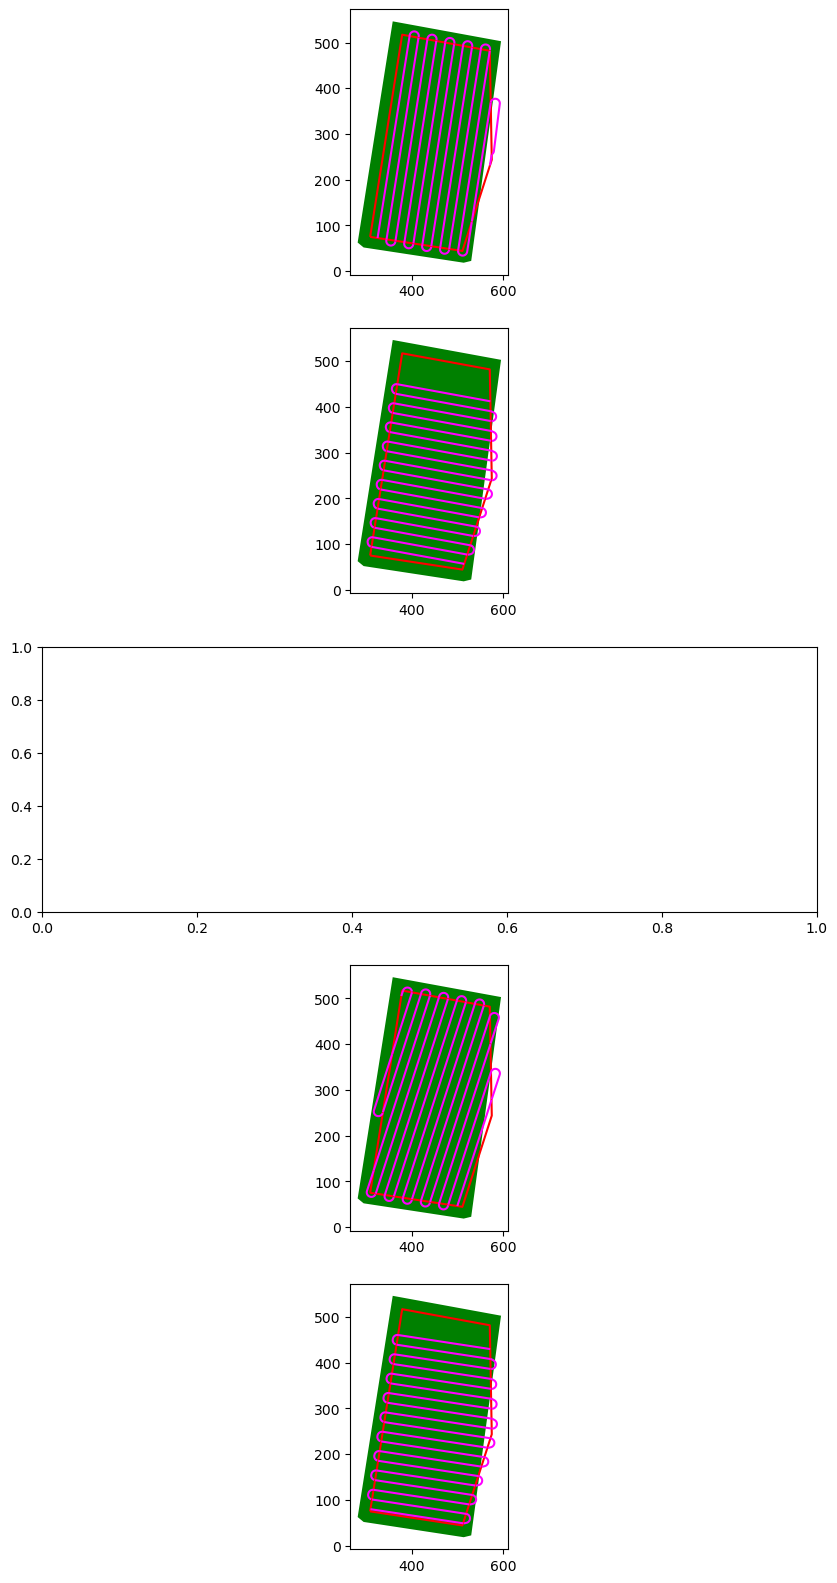

In [105]:
fig, ax = plt.subplots(len(coordinates)-1,1,figsize = (10,20))
coordinates = field1_with_headlands.get_coordinates()
lines = edge_to_line(coordinates)
turning_rad = 10
for i in range(len(coordinates)-1):
    try:
        line,slope = basis_AB_line(lines.iloc[i],coordinates)
        swath_list = fill_field_AB(line,slope,coordinates,20)
        swaths_clipped = clip_swaths(swath_list,field1_with_headlands)
        
        if slope > 0:
            offset = 0
        else:
            offset = 180
        path = generate_path(swaths_clipped,turning_rad,offset)

        field.plot(ax = ax[i],color = 'g')
        field1_with_headlands.boundary.plot(ax = ax[i],color = 'r')
        for ii in range(len(path)):
            path[ii].plot(ax = ax[i], color = 'magenta');
    except:
        continue

In [17]:
def pathplanning(data_path,include_obs,turning_rad,distance,plotting,headland_size, interpolation_dist):
    """
    main function for the pathplanning, loads the data and generates a path (maybe its better to make this a class but idk)
    
    args:
        data_path (str): filepath that contains the json file to be parsed
        include_obs (bool): boolean to indicate if you want to include the obstacles in the 
                            resulting field (will probably be usefull for some debugging)
        turning_rad (float): turning radius of the tractor in m
        distance (float): distance between swaths in m
        plotting (bool): boolean to decide whether you want to plot the generated path or not
        headland_size (float): size of the headlands in m
        interpolation_dist (float): the distance between points in the straight line segment

    returns:
        field (geopandas Geoseries): The polygon that defines the field
        best_path (pandas DataFrame): Dataframe containing the xy coordinates of each checkpoint of the path. 

    """
    field = load_data(data_path,include_obs) 
    field_headlands = generate_headlands(field,headland_size)
    coordinates = field_headlands.get_coordinates()
    lines = edge_to_line(coordinates)
    
    # Initialize emtpy lists to contain the generated paths and path lengths
    paths = [] 
    path_lengths = []

    for i in range(len(coordinates)-1): # Loop over all of the edges
        print('Finding path {}/{}'.format(i,len(coordinates)-1))
        try:
            # Calculate the basis AB line, use that to fill the field and clip the swaths
            line,slope = basis_AB_line(lines.iloc[i],coordinates)
            swath_list = fill_field_AB(line,slope,coordinates,distance)
            swaths_clipped = clip_swaths(swath_list,field_headlands)
            
            # If the paths have a negative slope, the heading is off by 180 degrees, this messes up the curves, so this offset is introduced
            if slope > 0:
                offset = 0
            else:
                offset = 180
            
            # Make a path with dubins curves
            path = generate_path(swaths_clipped,turning_rad,offset)
            # Interpolate the path with some specified distance
            path = interpolate_path(path,interpolation_dist)
            paths.append(path)

            # Calculate path lenght as a measure of how good a path is, this should be replaced with a different measure
            total_len = 0
            for i in range(len(path)):
                total_len+= path[i].length.item()
            path_lengths.append(total_len)
        except Exception as error: # Error handling to make sure the loop continues if an error pops up
            paths.append(None)
            path_lengths.append(0)
            print(error)
            continue

    # Finding the path with the best measure
    best_path_index = np.argmax(path_lengths)
    best_path = paths[best_path_index]
    # Converting path to df
    best_path = path_to_df(best_path)

    # Plot the path if it is specified
    if plotting:
        fig, ax = plt.subplots()
        field.plot(ax = ax,color = 'g')
        field_headlands.boundary.plot(ax = ax,color = 'r')
        best_path.plot(x = 'x', y = 'y',ax = ax,color = 'magenta')
        plt.show()
    
    return field,best_path




Finding path 0/5
Finding path 1/5
Finding path 2/5
No swaths were generated, something went wrong with clipping
Finding path 3/5
Finding path 4/5


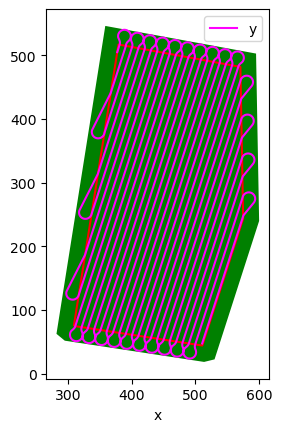

In [22]:
data_path ="./data/field_geometry/test_2.json"
include_obs = False
turning_rad = 10
distance = 10
field, best_path = pathplanning(data_path,include_obs,turning_rad,distance,True,25,5)

Below generates a gif of the path followed, yes i get distracted easily

IndexError: single positional indexer is out-of-bounds

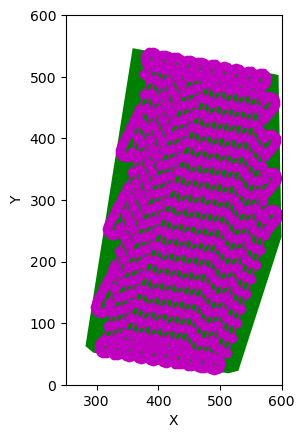

In [23]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
field.plot(ax = ax,color = 'g')

xdata, y = [], []

graph1, = ax.plot([], [], 'mo-')

# set up the plot
plt.xlim(250, 600)
plt.xlabel('X')
plt.ylim(0, 600)
plt.ylabel('Y')

# animation function
def animate(i):
    xdata.append(best_path.iloc[5*i]['x'])
    y.append(best_path.iloc[5*i]['y'])
    graph1.set_data(xdata, y)

    return (graph1,)

anim = animation.FuncAnimation(fig, animate,  frames=1000, interval=10, blit=True)
# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=60)
anim.save('scatter.gif', writer=writer)
plt.show()

In [152]:
list(best_path.itertuples(index = False,name = None))

[(377.1540180066696, 505.1475248911465),
 (378.68681264571967, 509.9067832991865),
 (380.2196072847697, 514.6660417072264),
 (380.90076305156674, 516.7809997242528),
 (381.1592583664239, 517.7465809567711),
 (381.32006500791925, 518.7331447755106),
 (381.38157624924656, 519.730833760909),
 (381.3431774904155, 520.7296793344162),
 (381.2052523991312, 521.7197013612364),
 (380.969179077314, 522.6910078685353),
 (380.63731629155984, 523.633893882763),
 (380.2129799051249, 524.5389383985423),
 (379.713988125155, 525.405396056408),
 (379.27144630725587, 526.301679317328),
 (378.9205943753575, 527.2376653569023),
 (378.66493792598726, 528.2040021120193),
 (378.5070313938784, 529.1910342652506),
 (378.4484525289028, 530.1888997175902),
 (378.4897866317158, 531.187628127289),
 (378.6306207056252, 532.177240530213),
 (378.86954758311805, 533.1478490463544),
 (379.20417998581325, 534.0897556762607),
 (379.6311743773578, 534.9935492002385),
 (380.14626437093705, 535.8501992121509),
 (380.74430335